In [1]:
!pip install lifetimes


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install openpyxl


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import lifetimes

import pandas as pd 
import numpy as np 
import datetime as dt 
import openpyxl

import matplotlib.pyplot as plt 
import seaborn as sns

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter 
from sklearn.preprocessing import MinMaxScaler

from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)

In [4]:
df = pd.read_excel("Online Retail.xlsx")

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [8]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country'], dtype='object')

In [9]:
df = df[df['Quantity']>0]
df = df[df['UnitPrice']>0]
df = df[~df['InvoiceNo'].str.contains('C',na=False)]

In [10]:
df.dropna(inplace=True)

In [11]:
def find_boundaries(df, variable,q1=0.05,q2=0.95):

    lower_boundary = df[variable].quantile(q1)
    upper_boundary = df[variable].quantile(q2)

    return upper_boundary,lower_boundary

def capping_outliers(df,variable):
    upper_boundary,lower_boundary = find_boundaries(df,variable)
    df[variable]=np.where(df[variable] > upper_boundary, upper_boundary,
                         np.where(df[variable]< lower_boundary,lower_boundary,df[variable]))

In [12]:
capping_outliers(df,'UnitPrice')
capping_outliers(df,'Quantity')

In [13]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,397884.000000,397884,397884.000000,397884.000000
mean,8.868022,2011-07-10 23:41:23.511023360,2.675785,15294.423453
min,1.000000,2010-12-01 08:26:00,0.420000,12346.000000
25%,2.000000,2011-04-07 11:12:00,1.250000,13969.000000
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000
75%,12.000000,2011-10-20 14:33:00,3.750000,16795.000000
max,36.000000,2011-12-09 12:50:00,8.500000,18287.000000
std,9.523425,NaN,2.275053,1713.141560


In [14]:
df = df[df.Country =='United Kingdom']

In [15]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [16]:
df['Total Price'] = df['UnitPrice'] * df['Quantity']

In [17]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [18]:
clv = lifetimes.utils.summary_data_from_transaction_data(df,'CustomerID','InvoiceDate','Total Price',observation_period_end='2011-12-09')

In [19]:
clv = clv[clv['frequency']>1]

In [20]:
clv.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12747.0,10.0,367.0,369.0,375.725000
12748.0,112.0,373.0,373.0,257.314911
12749.0,3.0,210.0,213.0,999.106667
12820.0,3.0,323.0,326.0,256.573333
12823.0,4.0,222.0,296.0,252.450000


In [21]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(clv['frequency'],clv['recency'],clv['T'])

<lifetimes.BetaGeoFitter: fitted with 1738 subjects, a: 0.00, alpha: 112.07, b: 0.00, r: 2.38>

In [22]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.381731e+00,1.013873e-01,2.183012e+00,2.580451e+00
alpha,1.120749e+02,5.267568e+00,1.017504e+02,1.223993e+02
a,2.301100e-14,3.668820e-10,-7.190657e-10,7.191117e-10
b,2.398753e-05,3.819870e-01,-7.486706e-01,7.487186e-01


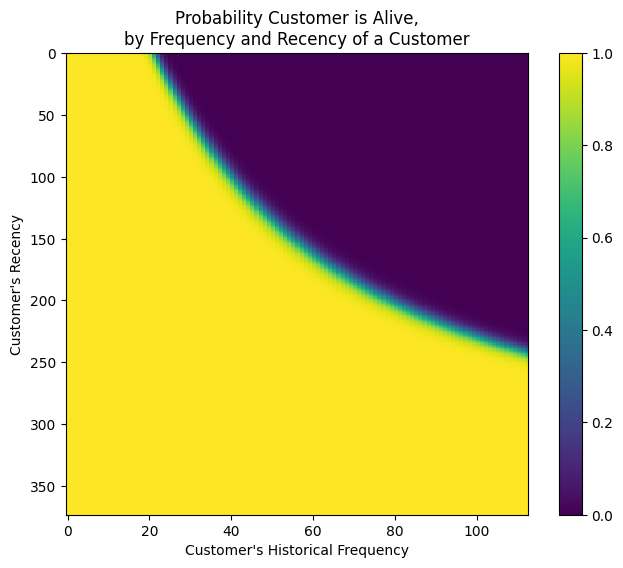

In [23]:
plt.figure(figsize=(8,6))
plot_probability_alive_matrix(bgf)
plt.show()

In [24]:
t = 180
clv['expected_purc_6_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t,clv['frequency'],clv['recency'], clv['T'])
clv.sort_values(by='expected_purc_6_months',ascending=False).head(5)

,frequency,recency,T,monetary_value,expected_purc_6_months
CustomerID,,,,,
12748.0,112.0,373.0,373.0,257.314911,42.444401
17841.0,111.0,372.0,373.0,349.079640,42.073324
15311.0,89.0,373.0,373.0,421.881573,33.909635
14606.0,88.0,372.0,373.0,125.302955,33.538559
12971.0,70.0,369.0,372.0,132.197571,26.914663


In [25]:
clv[['frequency','monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.082631
monetary_value,0.082631,1.000000


In [26]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(clv['frequency'],
       clv['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 1738 subjects, p: 3.80, q: 0.35, v: 3.73>

In [27]:
clv['6_Months_clv']=ggf.customer_lifetime_value(bgf,
                                               clv['frequency'],
                                               clv['recency'],
                                               clv['T'],
                                               clv['monetary_value'],
                                               time =6,
                                               freq='D',
                                               discount_rate=0.01)

In [28]:
clv.sort_values('6_Months_clv',ascending=False).head()

,frequency,recency,T,monetary_value,expected_purc_6_months,6_Months_clv
CustomerID,,,,,,
14096.0,16.0,97.0,101.0,3012.454375,15.528400,45677.610915
18102.0,25.0,367.0,367.0,2112.843200,10.287978,21142.592872
13089.0,65.0,367.0,369.0,784.818308,25.211693,19164.137958
17511.0,27.0,371.0,373.0,1798.113704,10.902877,19058.975876
14088.0,11.0,312.0,322.0,3352.988182,5.549070,18258.492844


In [29]:
clv['Segment']=pd.qcut(
    clv['6_Months_clv'],
    q=4,
    labels=['Hibernating','Need Attention','Loyal Customer','Champions']
    
)

In [30]:
clv.head()

,frequency,recency,T,monetary_value,expected_purc_6_months,6_Months_clv,Segment
CustomerID,,,,,,,
12747.0,10.0,367.0,369.0,375.725000,4.632775,1712.381633,Champions
12748.0,112.0,373.0,373.0,257.314911,42.444401,10566.853327,Champions
12749.0,3.0,210.0,213.0,999.106667,2.979965,3054.158128,Champions
12820.0,3.0,323.0,326.0,256.573333,2.211293,584.100407,Need Attention
12823.0,4.0,222.0,296.0,252.450000,2.814953,719.842220,Need Attention


In [31]:
clv.groupby('Segment').mean()

,frequency,recency,T,monetary_value,expected_purc_6_months,6_Months_clv
Segment,,,,,,
Hibernating,3.174713,221.337931,292.245977,147.152900,2.553847,364.667903
Need Attention,4.027650,240.140553,284.440092,265.378345,2.989161,745.573232
Loyal Customer,5.592166,242.944700,276.027650,365.362234,3.759721,1234.753807
Champions,11.108046,261.354023,280.475862,584.771128,5.994943,3095.935737


In [32]:
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [33]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [34]:
df = df.dropna(subset=['CustomerID'])

In [35]:
df['Total Price'] = df['Quantity'] * df['UnitPrice']

In [36]:
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)

In [37]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  
    'InvoiceNo': 'count',                                     
    'Total Price': 'sum'                                       
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Total Price': 'Monetary'
})

In [38]:
rfm['AOV'] = rfm['Monetary'] / rfm['Frequency']

In [39]:
rfm['clv'] = rfm['Monetary']

In [42]:
X = rfm[['Recency', 'Frequency', 'AOV']]
Y = rfm['clv']

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

In [44]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

In [47]:
mae = mean_absolute_error(Y_test, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

In [48]:
print(f"Model performance:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}")

Model performance:
MAE: 112.74
RMSE: 1217.20


In [49]:
rfm['PredictedCLV'] = model.predict(X)
rfm['CLV_Segment'] = pd.qcut(
    rfm['PredictedCLV'], q=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])

In [51]:
print("\nSample predictions with segments:\n", rfm[['PredictedCLV', 'CLV_Segment']].head())


Sample predictions with segments:
             PredictedCLV CLV_Segment
CustomerID                          
12346.0          38.0192         Low
12747.0        4095.7803        High
12748.0       27774.0154        High
12749.0        3792.4316        High
12820.0         943.0784    Mid-High


In [52]:
rfm.reset_index().to_csv("final_clv_predictions.csv", index=False)
print("\nFinal predictions saved as final_clv_predictions.csv")


Final predictions saved as final_clv_predictions.csv


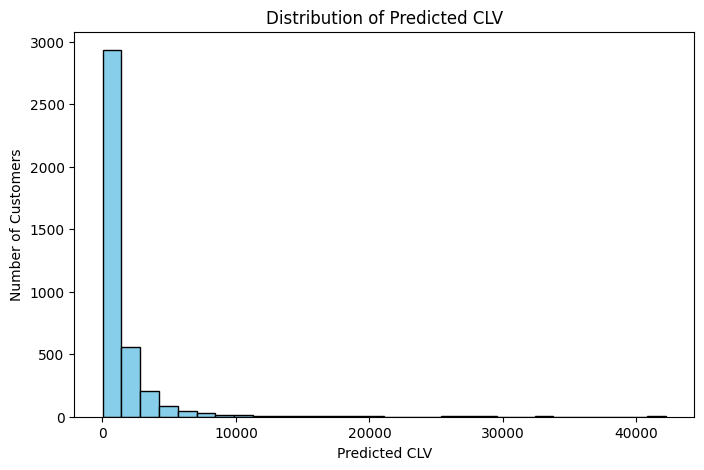

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(rfm['PredictedCLV'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Predicted CLV")
plt.xlabel("Predicted CLV")
plt.ylabel("Number of Customers")
plt.show()

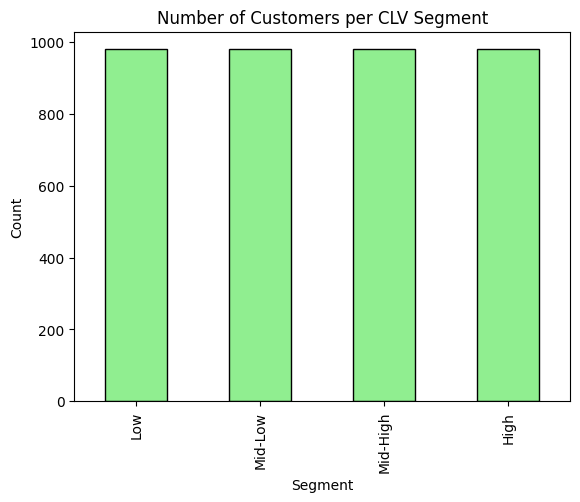

In [54]:
rfm['CLV_Segment'].value_counts().sort_index().plot(
    kind='bar', color='lightgreen', edgecolor='black')
plt.title("Number of Customers per CLV Segment")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.show()